<span style="font-size:30px;">Task 7: Time Series Breakdown of Retail Sales.</span>

<span style="font-size:20px;">1. Load & Clean Data.</span>

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [38]:
df = pd.read_csv(r"/Users/jojo/elevvo internship/Task 7/train.csv")

In [39]:
df.shape

(421570, 5)

In [40]:
df.columns

Index(['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday'], dtype='object')

In [41]:
df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [42]:
# Basic sanity checks
expected_cols = {"Store", "Dept", "Date", "Weekly_Sales", "IsHoliday"}
missing = expected_cols - set(df.columns)
if missing:
    raise ValueError(f"Missing expected columns: {missing}")


In [43]:
# Parse dates & coerce types
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
df = df.dropna(subset=["Date"])
df["Weekly_Sales"] = pd.to_numeric(df["Weekly_Sales"], errors="coerce")
df = df.dropna(subset=["Weekly_Sales"])

<span style="font-size:20px;">2. Build monthly series.</span>

In [44]:
# Total monthly sales across all stores & depts
monthly_total = (
    df.groupby(pd.Grouper(key="Date", freq="MS"))["Weekly_Sales"]
      .sum()
      .rename("sales")
      .to_frame()
)

In [45]:
# Monthly by Dept (product)
monthly_dept = (
    df.groupby([pd.Grouper(key="Date", freq="MS"), "Dept"])["Weekly_Sales"]
      .sum()
      .reset_index()
      .pivot(index="Date", columns="Dept", values="Weekly_Sales")
      .sort_index()
)

In [46]:
# Monthly by Store (proxy for region)
monthly_store = (
    df.groupby([pd.Grouper(key="Date", freq="MS"), "Store"])["Weekly_Sales"]
      .sum()
      .reset_index()
      .pivot(index="Date", columns="Store", values="Weekly_Sales")
      .sort_index()
)


<span style="font-size:20px;">3. Trend + Moving Averages.</span>

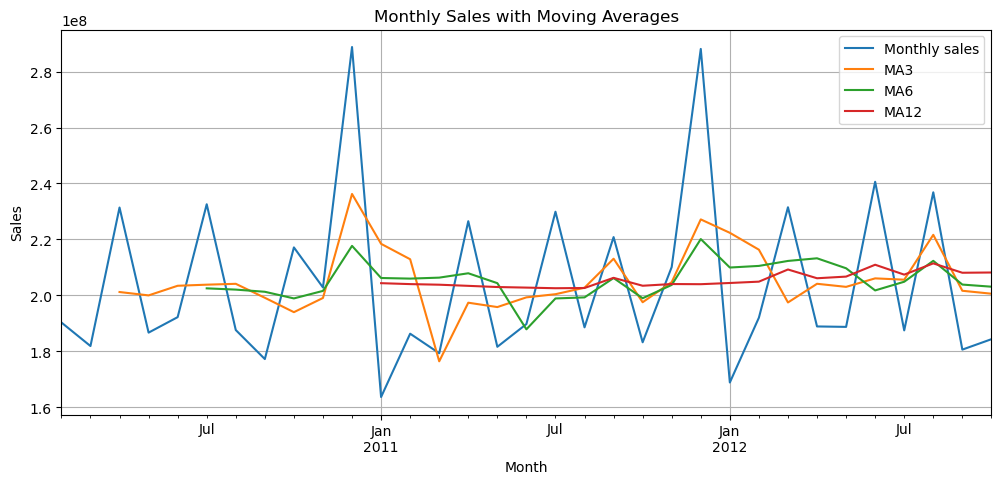

In [47]:
ROLL_WINDOWS = [3, 6, 12]  # for 3-month, 6-month, and 12-month moving averages

for w in ROLL_WINDOWS:
    monthly_total[f"MA{w}"] = monthly_total["sales"].rolling(w).mean()

fig, ax = plt.subplots(figsize=(12,5))
monthly_total["sales"].plot(ax=ax, label="Monthly sales")
for w in ROLL_WINDOWS:
    monthly_total[f"MA{w}"].plot(ax=ax, label=f"MA{w}")
ax.set_title("Monthly Sales with Moving Averages")
ax.set_xlabel("Month")
ax.set_ylabel("Sales")
ax.grid(True)
ax.legend()
plt.show()

<span style="font-size:20px;">4. Seasonal pattern.</span>

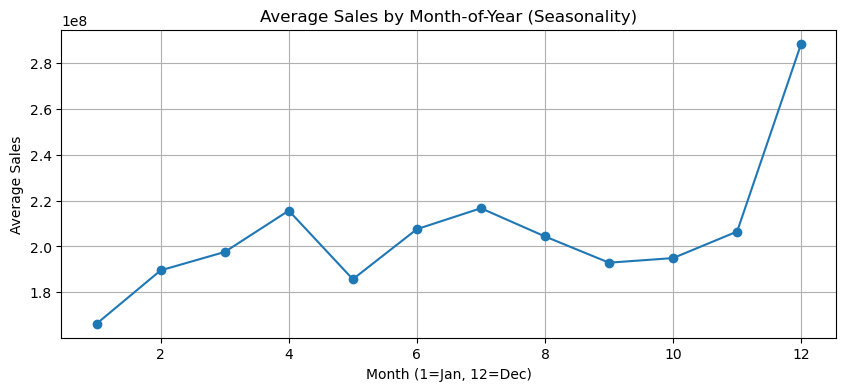

In [48]:
seasonal = (
    monthly_total.assign(month=monthly_total.index.month)
                 .groupby("month")["sales"]
                 .mean()
                 .reindex(range(1,13))
)

fig, ax = plt.subplots(figsize=(10,4))
seasonal.plot(ax=ax, marker="o")
ax.set_title("Average Sales by Month-of-Year (Seasonality)")
ax.set_xlabel("Month (1=Jan, 12=Dec)")
ax.set_ylabel("Average Sales")
ax.grid(True)
plt.show()

<span style="font-size:20px;">5. Breakdown by DEPT.</span>

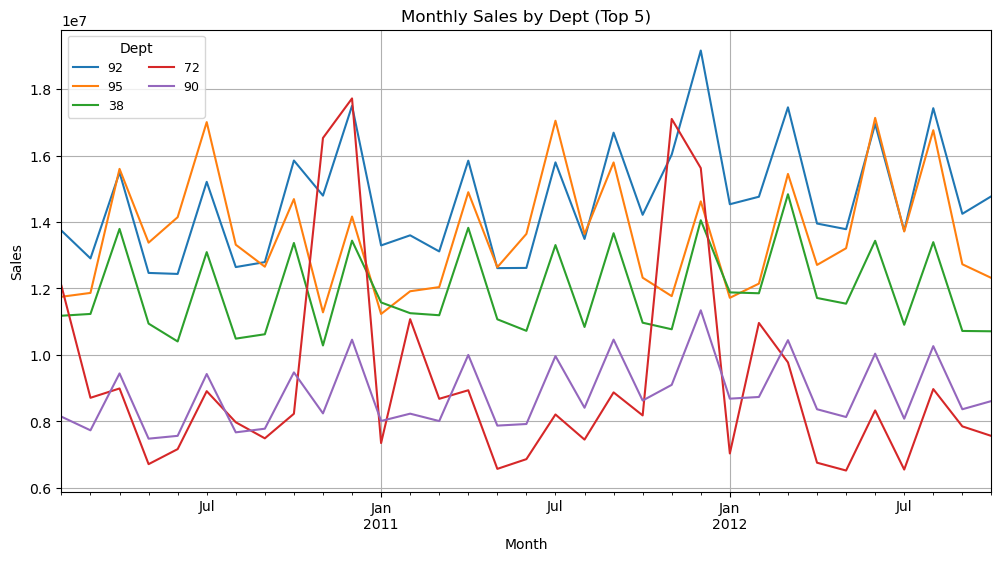

In [49]:
# We'll plot the top-N depts by total sales to keep the chart readable.

TOP_N_DEPTS = 5  # You can change this value to show more or fewer departments

top_depts = monthly_dept.sum().nlargest(TOP_N_DEPTS).index
fig, ax = plt.subplots(figsize=(12,6))
monthly_dept[top_depts].plot(ax=ax)
ax.set_title(f"Monthly Sales by Dept (Top {TOP_N_DEPTS})")
ax.set_xlabel("Month")
ax.set_ylabel("Sales")
ax.grid(True)
ax.legend(title="Dept", ncol=2, fontsize=9)
plt.show()

<span style="font-size:20px;">6. Breakdown by 'Store'.</span>

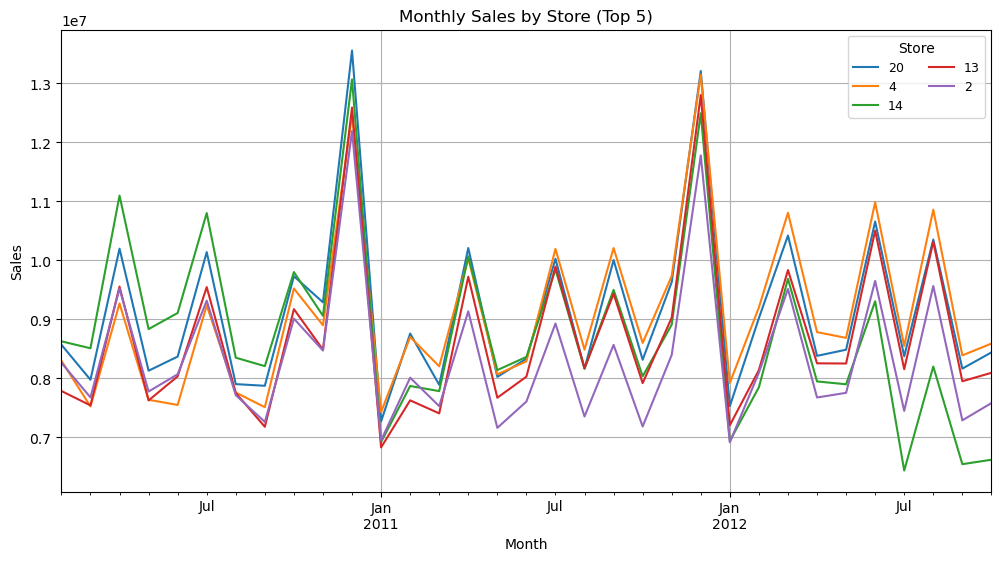

In [50]:
TOP_N_STORES = 5  # You can change this to any number you prefer

top_stores = monthly_store.sum().nlargest(TOP_N_STORES).index
fig, ax = plt.subplots(figsize=(12,6))
monthly_store[top_stores].plot(ax=ax)
ax.set_title(f"Monthly Sales by Store (Top {TOP_N_STORES})")
ax.set_xlabel("Month")
ax.set_ylabel("Sales")
ax.grid(True)
ax.legend(title="Store", ncol=2, fontsize=9)
plt.show()

<span style="font-size:30px;">BONUS TASKS.</span>

In [51]:
def train_test_split_series(s, test_h):
    s = s.dropna()
    if len(s) <= test_h + 1:
        raise ValueError("Series too short for the requested TEST_H.")
    return s.iloc[:-test_h], s.iloc[-test_h:]

# Define TEST_H before using it
TEST_H = 12  # Example: using 12 months for testing, adjust as needed

series = monthly_total["sales"].copy()
train, test = train_test_split_series(series, TEST_H)

In [52]:
# Rolling-mean forecast: constant forecast = mean of last k train observations
def rolling_mean_forecast(train_series, k, h, index_like=None):
    k = int(k)
    last_k = train_series.dropna().tail(k)
    if len(last_k) == 0:
        raise ValueError("Not enough history for rolling-mean forecast.")
    fc_value = last_k.mean()
    if index_like is None:
        # forecast months immediately after train end
        start = train_series.index[-1] + pd.offsets.MonthBegin(1)
        index_like = pd.date_range(start=start, periods=h, freq="MS")
    return pd.Series([fc_value]*h, index=index_like)

In [53]:
# Simple Exponential Smoothing (no external libs)
def ses_level(train_series, alpha):
    # returns the last smoothed level
    s = train_series.dropna().values
    level = s[0]
    for y in s[1:]:
        level = alpha*y + (1-alpha)*level
    return level

def ses_forecast(train_series, alpha, h, index_like=None):
    level = ses_level(train_series, alpha)
    if index_like is None:
        start = train_series.index[-1] + pd.offsets.MonthBegin(1)
        index_like = pd.date_range(start=start, periods=h, freq="MS")
    return pd.Series([level]*h, index=index_like)

In [54]:
MA_K = 3  # Moving average window size
TEST_H = 12  # Test horizon/forecast period 
SES_ALPHA = 0.2  # Simple exponential smoothing alpha parameter

# predict on test for evaluation
rm_pred_test = rolling_mean_forecast(train, MA_K, TEST_H, index_like=test.index)
ses_pred_test = ses_forecast(train, SES_ALPHA, TEST_H, index_like=test.index)

In [55]:
# Metrics
def mae(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs(y_true - y_pred))

def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    denom = np.where(y_true==0, np.nan, y_true)
    return np.nanmean(np.abs((y_true - y_pred) / denom)) * 100

results = pd.DataFrame({
    "MAE": [mae(test, rm_pred_test), mae(test, ses_pred_test)],
    "MAPE_%": [mape(test, rm_pred_test), mape(test, ses_pred_test)]
}, index=["RollingMean", "SES(alpha={})".format(SES_ALPHA)])
print(results)


                         MAE     MAPE_%
RollingMean     2.593233e+07  11.460602
SES(alpha=0.2)  2.642921e+07  11.885036


<span style="font-size:20px;">Actual vs Forecasts</span>

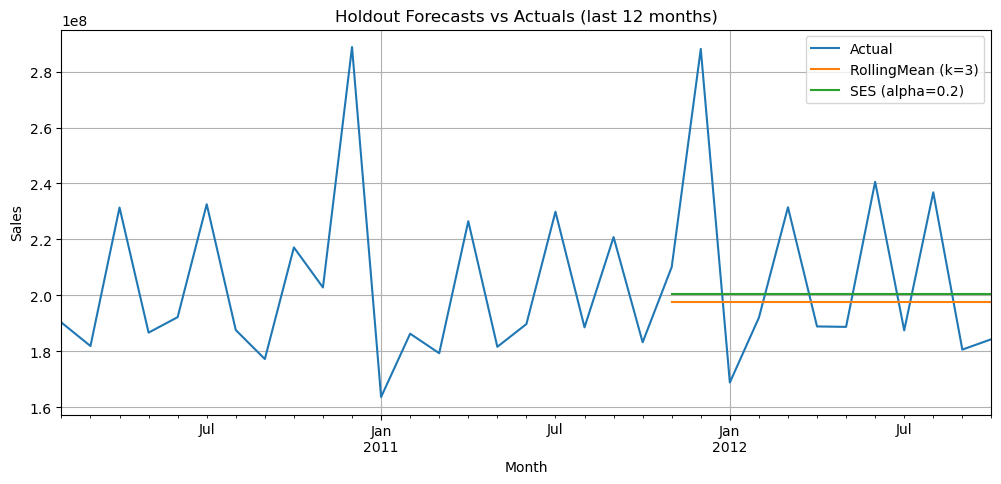

In [56]:
# Plot actual vs forecasts on test window
fig, ax = plt.subplots(figsize=(12,5))
series.plot(ax=ax, label="Actual")
rm_pred_test.plot(ax=ax, label=f"RollingMean (k={MA_K})")
ses_pred_test.plot(ax=ax, label=f"SES (alpha={SES_ALPHA})")
ax.set_title("Holdout Forecasts vs Actuals (last {} months)".format(TEST_H))
ax.set_xlabel("Month")
ax.set_ylabel("Sales")
ax.grid(True)
ax.legend()
plt.show()

<span style="font-size:20px;">Forecast next 6 months beyond dataset end.</span>



,RollingMean_Forecast,SES_Forecast
2012-11-01,2.006193e+08,2.015474e+08
2012-12-01,2.006193e+08,2.015474e+08
2013-01-01,2.006193e+08,2.015474e+08
2013-02-01,2.006193e+08,2.015474e+08
2013-03-01,2.006193e+08,2.015474e+08
2013-04-01,2.006193e+08,2.015474e+08
2013-05-01,2.006193e+08,2.015474e+08
2013-06-01,2.006193e+08,2.015474e+08
2013-07-01,2.006193e+08,2.015474e+08
2013-08-01,2.006193e+08,2.015474e+08


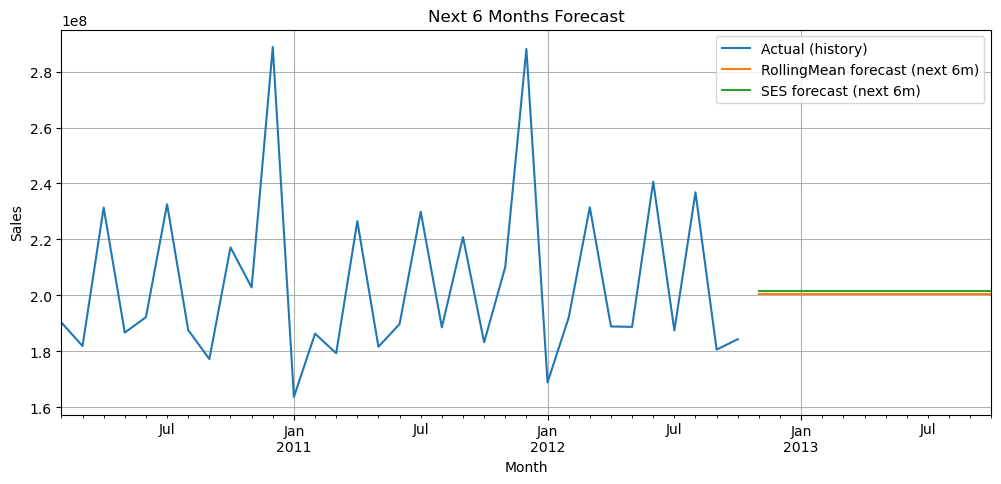

In [57]:
rm_future = rolling_mean_forecast(series, MA_K, TEST_H)
ses_future = ses_forecast(series, SES_ALPHA, TEST_H)

future_df = pd.DataFrame({
    "RollingMean_Forecast": rm_future,
    "SES_Forecast": ses_future
})
display(future_df)

fig, ax = plt.subplots(figsize=(12,5))
series.plot(ax=ax, label="Actual (history)")
rm_future.plot(ax=ax, label="RollingMean forecast (next 6m)")
ses_future.plot(ax=ax, label="SES forecast (next 6m)")
ax.set_title("Next 6 Months Forecast")
ax.set_xlabel("Month")
ax.set_ylabel("Sales")
ax.grid(True)
ax.legend()
plt.show()